In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys


In [2]:
# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [4]:
df, dfc, tensor, static = create_region_df_dfc_static(region, year)
L = get_L(static)
T_constant = np.ones(12).reshape(-1, 1)

In [48]:
k = weight[:5]
k[2]= 2
# np.repeat(k.reshape(-1, 1), 8, axis=1).reshape(5, 2, 4)
np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)

array([[ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589],
       [ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589],
       [ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589],
       [ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589],
       [ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  0.93626589],
       [ 0.93626589,  0.93626589,  0.93626589,  0.93626589,  0.93626589,
         0.93626589,  

In [ ]:
n_splits = 10
kf = KFold(n_splits=n_splits)

num_home_factor = 3
num_season_factor = 3
case = 2
prediction = {}
num_iterations = 5
num_random_seed = 5

for random_seed in range(num_random_seed):
    prediction[random_seed] = {}
    for iterations in range(num_iterations):
        prediction[random_seed][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            prediction[random_seed][iterations][appliance] = []
        


for random_seed in range(num_random_seed):
    random.seed(random_seed)
    
    for train_validate, test in kf.split(df):
            
        num_train_validate = len(train_validate)
        num_test = len(test)
            
        # randomly select the validation data
        # may need more iterations for different random values
        validate = random.sample(train_validate, int(0.1*num_train_validate))
        train = list(set(train_validate) - set(validate))
        
        # get the index of train, validation and test data
        train_ix = df.index[train]
        test_ix = df.index[test]
        validate_ix = df.index[validate]

        
        for iteration in range(num_iterations):
            
            print 'Iteration: ', iteration
            num_train = len(train)
            num_test = len(test)
            num_validate = len(validate)
            
            train_df = df.loc[train_ix]
            tensor_train = get_tensor(train_df)
            
            test_validate_ix = np.concatenate([test_ix, validate_ix])
            tv_df = df.loc[test_validate_ix]
            tensor_tv = get_tensor(tv_df)
            
            # train model with tensor_train
            tensor_copy = tensor_train.copy()
            L_train = L[np.ix_(train, train)]
            
            if iteration == 0: 
                m, n, o = tensor_copy.shape
                weight_matrix = tensor_copy.copy()
                weight_matrix[:, :, :] = 1
   
            H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L_train,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                     weight_matrix,
                                                                      num_iter=1300,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                      T_known=T_constant)
    
            
            # create test_validate tensor
            tensor_copy = tensor_tv.copy()
            L_tv = L[np.ix_(np.concatenate([test, validate]), np.concatenate([test, validate]))]
            
            if iteration == 0:
                m, n, o = tensor_copy.shape
                weight_tv = tensor_copy.copy()
                weight_tv[:, :, :] = 1

            H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L_tv,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                     weight_tv,
                                                                      num_iter=1300,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                    A_known = A_train,
                                                                      T_known=T_train)
            
#             save the result for this iteration.
            HAT = multiply_case(H_tv, A_tv, T_tv, case)
            for appliance in APPLIANCES_ORDER:
                prediction[random_seed][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
  
            H_tr_v = np.r_[H_train, H_tv[num_test:]]
    
            similarities = cosine_similarity(H_tr_v)
            sim = similarities[:num_train, num_train:]
            sim = sim.max(axis=1)
            print sim.shape
            weight = sim
            weight_matrix = np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    

#             # set appliances' readings of test data to be MISSING
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             if iteration == 0: 
#                 m, n, o = tensor_copy.shape
#                 weight_matrix = tensor.copy()
#                 weight_matrix[:, :, :] = 1
            
#             # Learn the model
#             H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
#                                                                        L,
#                                                                       num_home_factor,
#                                                                       num_season_factor,
#                                                                        weight_matrix,
#                                                                       num_iter=1300,
#                                                                       lr=0.1, dis=True,
#                                                                       lam=0,
#                                                                       T_known=T_constant)
            
#             # save the result for this iteration.
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 prediction[random_seed][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
            
#             H_train = H[num_test:(num_test+num_train), :]
#             H_validate = H[(num_test + num_train):, :]
            
#             similarities = cosine_similarity(H[num_test:, :])
#             sim = similarities[:num_train, num_train:]
# #             print sim.shape
#             sim = sim.mean(axis=1)
#             print sim.shape
#             weight = np.r_[np.ones(num_test), sim, np.ones(num_validate)]
#             print weight.shape
#             weight_matrix = np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    
            
            
            
            ##############################################################################################
            # Only consider the home factors learned to select data
#             H_validate = H[(num_test + num_selected):, :]
#             H_selected = H[num_test:(num_test + num_selected), :]
#             H_combine = np.r_[H_selected, H_validate]
#             H_combine = H_combine/np.max(H_combine)
#             cluster_pred = KMeans(n_clusters = 20, random_state = 0).fit_predict(H_combine)
#             selected_cluster = set(cluster_pred[:num_selected])
#             validate_cluster = set(cluster_pred[num_selected:])

            
#             selected = [i for i, j in enumerate(cluster_pred[:num_selected]) if j in validate_cluster]
#             removed = list(set(train) - set(selected))
            ##############################################################################################

Iteration:  0
505.260030227
142.371968305
98.2005105229
414.674524902
146.28035617
109.55546707
(432,)
Iteration:  1
469.948840032
131.916968711
90.7654324472
414.466566886
145.763786447
109.487481229
(432,)
Iteration:  2
471.573136433
132.409963437
91.1234219384
414.49068045
145.830953901
109.513381403
(432,)
Iteration:  3
471.523918016
132.394238815
91.1116847769
414.489691743
145.828338321
109.512625515
(432,)
Iteration:  4
471.527840096
132.39547841
91.1126033283
414.489771087
145.828550454
109.512690787
(432,)
Iteration:  0
496.035416963
139.470499164
100.213864937
448.427798623
154.201241779
111.106058756
(432,)
Iteration:  1
466.969540916
130.535687087
93.6312185891
448.168430288
153.597174504
111.09849184
(432,)
Iteration:  2
467.459318733
130.744820843
93.8021499183
448.203622796
153.684581374
111.124620417
(432,)
Iteration:  3
467.452213641
130.738367596
93.7966012389
448.201793733
153.68020962
111.123855397
(432,)
Iteration:  4
467.454202984
130.739346725
93.7973692653
448.2

472.623686291
173.066405356
120.755040239
(432,)
Iteration:  4
468.753726841
131.192965143
92.8621034497
472.623818616
173.066830712
120.755185898
(432,)
Iteration:  0
506.261785873
140.102733362
98.1104006989
407.096800997
136.103706575
104.767706284
(432,)
Iteration:  1
474.129004533
130.335358303
90.8960184756
406.856128758
135.726517089
105.107979477
(432,)
Iteration:  2
476.803498283
131.166233585
91.5273981913
406.882323268
135.770441918
105.080313731
(432,)
Iteration:  3
476.547025435
131.084700094
91.4646127821
406.880092244
135.767580641
105.085639407
(432,)
Iteration:  4
476.588074584
131.09787379
91.4748582071
406.880477571
135.76807452
105.084715441
(432,)
Iteration:  0
503.216181972
143.201949453
98.8841917141
419.115030369
127.401921179
100.679223385
(432,)
Iteration:  1
478.829484186
135.485726154
93.1934747728
418.885065057
127.038257176
100.945439129
(432,)
Iteration:  2
481.097989956
136.217034052
93.7411355493
418.923146226
127.112374175
100.942118621
(432,)
Iteratio

(432,)
Iteration:  2
452.981278801
126.071257757
89.8624047024
451.955043542
162.046315727
117.675138787
(432,)
Iteration:  3
452.800050717
126.015634113
89.8212052638
451.952782556
162.04016891
117.673746511
(432,)
Iteration:  4
452.818710504
126.021330446
89.8253915346
451.953006152
162.040802265
117.673925792
(432,)
Iteration:  0
498.343235895
141.916535631
99.70084893
437.696032865
130.988200071
98.4619518283
(432,)
Iteration:  1
461.261973547
130.555514676
91.5775849904
437.336252673
130.353120587
98.6790535629
(432,)
Iteration:  2
463.289432018
131.194949509
92.0468209886
437.367262754
130.407542082
98.6683139078
(432,)
Iteration:  3
463.170067771
131.158144155
92.0200593924
437.366375152
130.405945522
98.6688951115
(432,)
Iteration:  4
463.179034539
131.160954298
92.0221046143
437.366490383
130.406154877
98.6688498477
(432,)
Iteration:  0
500.74639081
136.692318174
100.347955123
432.349785381
171.079029505
122.100104405
(432,)
Iteration:  1
464.271322505
126.092557527
92.4839480

In [31]:
out = {}
for random_seed in range(5):
    out[random_seed] = {}
    for iteration in range(num_iterations):
        out[random_seed][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(prediction[random_seed][iteration][appliance]).loc[df.index]
            if appliance=="hvac":
                out[random_seed][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)],region)[2]
            else:   
                out[random_seed][iteration][appliance] = compute_rmse_fraction(appliance, s,region)[2]

In [32]:
mean_out = pd.Panel(out).mean(axis=0)
mean_out

,0,1,2,3,4
dw,1.272974,1.273191,1.273066,1.273053,1.273130
fridge,5.316447,5.390875,5.364818,5.377455,5.364771
hvac,15.483085,15.597037,15.582080,15.585152,15.583726
mw,1.632471,1.641693,1.639947,1.640968,1.640535
oven,1.520939,1.522131,1.521943,1.522146,1.522171
wm,0.632618,0.635626,0.634917,0.635311,0.635149


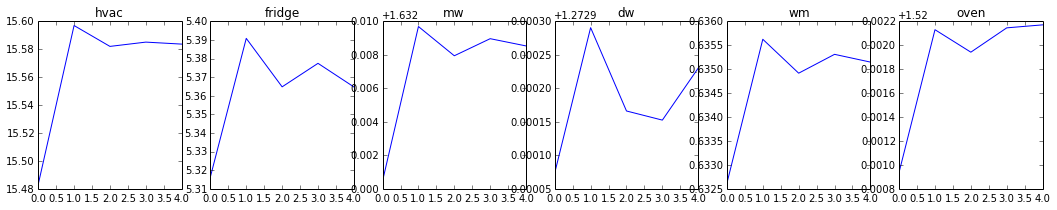

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)
    count += 1

# plt.savefig("Result_remove_cluster.png")

In [5]:
n_splits = 10
kf = KFold(n_splits=n_splits)

num_home_factor = 3
num_season_factor = 3
case = 2
prediction = {}
num_iterations = 5
num_random_seed = 1

for random_seed in range(num_random_seed):
    prediction[random_seed] = {}
    for iterations in range(num_iterations):
        prediction[random_seed][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            prediction[random_seed][iterations][appliance] = []
        


for random_seed in range(num_random_seed):
    random.seed(random_seed)
    
    for train_validate, test in kf.split(df):
            
        num_train_validate = len(train_validate)
        num_test = len(test)
            
        # randomly select the validation data
        # may need more iterations for different random values
        validate = random.sample(train_validate, int(0.1*num_train_validate))
        train = list(set(train_validate) - set(validate))
        
        # get the index of train, validation and test data
        train_ix = df.index[train]
        test_ix = df.index[test]
        validate_ix = df.index[validate]
        
        #####################################################
#         # set initial selected data and removed data
#         selected = train
#         removed = list(set(train) - set(selected))
#         selected_ix = df.index[selected]
#         removed_ix = df.index[removed]
        #####################################################
        
        for iteration in range(num_iterations):
            
            print 'Iteration: ', iteration
#             num_test = len(test)
#             num_selected = len(selected)
#             num_validate = len(validate)
            num_train = len(train)
            num_test = len(test)
            num_validate = len(validate)
            
            ############################################################################
#             selected_ix = df.index[selected]
#             removed_ix = df.index[removed]
            
#             L_inner = L[np.ix_(np.concatenate([test, selected, validate]), np.concatenate([test, selected, validate]))]
#             selected_validate_test_ix = np.concatenate([test_ix, selected_ix, validate_ix])
#             df_inner, dfc_inner = df.loc[selected_validate_test_ix], dfc.loc[selected_validate_test_ix]
#             tensor = get_tensor(df_inner)
            ################################################################################
            
            test_train_validate_ix = np.concatenate([test_ix, train_ix, validate_ix])
            df_inner = df.loc[test_train_validate_ix]
            tensor = get_tensor(df_inner)
            tensor_copy = tensor.copy()
            # set appliances' readings of test data to be MISSING
            tensor_copy[:num_test, 1:, :] = np.NaN
#             m, n, o = tensor_copy.shape
#             weight_matrix = tensor.copy()
#             weight_matrix[:,:,:]=1
            if iteration == 0: 
                m, n, o = tensor_copy.shape
                weight_matrix = tensor.copy()
                weight_matrix[:, :, :] = 1
            
            # Learn the model
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                       weight_matrix,
                                                                      num_iter=1300,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                      T_known=T_constant)
            
            # save the result for this iteration.
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                prediction[random_seed][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
            
            H_train = H[num_test:(num_test+num_train), :]
            H_validate = H[(num_test + num_train):, :]
            
            similarities = cosine_similarity(H[num_test:, :])
            sim = similarities[:num_train, num_train:]
#             print sim.shape
            sim = sim.mean(axis=1)
            print sim.shape
            weight = np.r_[np.ones(num_test), sim, np.ones(num_validate)]
            print weight.shape
            weight_matrix = np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    
            
            
            
            ##############################################################################################
            # Only consider the home factors learned to select data
#             H_validate = H[(num_test + num_selected):, :]
#             H_selected = H[num_test:(num_test + num_selected), :]
#             H_combine = np.r_[H_selected, H_validate]
#             H_combine = H_combine/np.max(H_combine)
#             cluster_pred = KMeans(n_clusters = 20, random_state = 0).fit_predict(H_combine)
#             selected_cluster = set(cluster_pred[:num_selected])
#             validate_cluster = set(cluster_pred[num_selected:])

            
#             selected = [i for i, j in enumerate(cluster_pred[:num_selected]) if j in validate_cluster]
#             removed = list(set(train) - set(selected))
            ##############################################################################################

Iteration:  0
519.448894999
181.759463335
113.080981643
(432,)
(533,)
Iteration:  1
499.547152936
174.307121416
108.59539905
(432,)
(533,)
Iteration:  2
499.882182743
174.437762952
108.675234846
(432,)
(533,)
Iteration:  3
499.881525842
174.437291635
108.674950475
(432,)
(533,)
Iteration:  4
499.881819054
174.437406745
108.67501253
(432,)
(533,)
Iteration:  0
514.090255833
179.343965453
111.205457742
(432,)
(533,)
Iteration:  1
498.008931725
173.234797336
107.165620404
(432,)
(533,)
Iteration:  2
498.814134513
173.537297384
107.359697598
(432,)
(533,)
Iteration:  3
498.814480759
173.536894678
107.359388315
(432,)
(533,)
Iteration:  4
498.815240022
173.537195883
107.359569211
(432,)
(533,)
Iteration:  0
517.038016556
179.33248519
111.596478323
(432,)
(533,)
Iteration:  1
496.691317735
171.828685833
106.799301202
(432,)
(533,)
Iteration:  2
497.471302926
172.115507513
106.981959308
(432,)
(533,)
Iteration:  3
497.462001176
172.112048306
106.979778738
(432,)
(533,)
Iteration:  4
497.46420

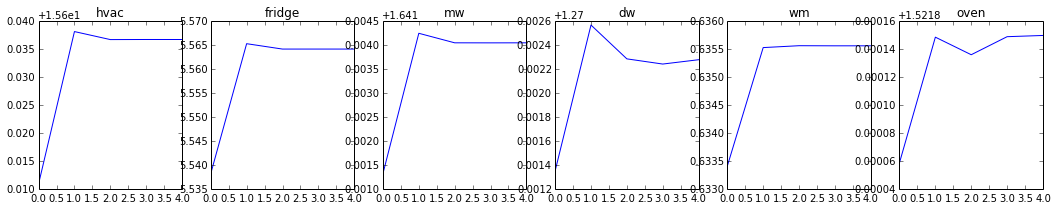

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)
    count += 1

# plt.savefig("Result_remove_cluster.png")

In [5]:
tensor_copy = source_tensor.copy()
tensor_copy[:, 1:, :] = np.NaN

In [10]:
from degree_days import dds

#For HVAC

In [11]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [50]:
hvac_tensor = get_tensor_appliance(source_df, source_dfc, 'fridge')
agg_tensor = get_tensor_appliance(source_df, source_dfc, 'aggregate')
tensor = np.concatenate((agg_tensor, hvac_tensor), axis=1)

In [73]:
known_homes = []
random_list =  random.sample(range(num_train), 50)
random_list =[x+1 for x in random_list]

pos = random_list[:50]
known_homes = known_homes+pos
# aggregate readings for all homes are known


In [ ]:
def compute_rmse_fraction(appliance, pred_df, region='Austin', year=2014):
	appliance_df = create_matrix_region_appliance_year(region, year, appliance)

	if appliance == "hvac":
		start, stop = 5, 11
	else:
		start, stop = 1, 13
	pred_df = pred_df.copy()
	pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
	gt_df = appliance_df[pred_df.columns].ix[pred_df.index]

	aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

	aggregate_df.columns = gt_df.columns
	rows, cols = np.where((aggregate_df < 100))
	for r, c in zip(rows, cols):
		r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
		aggregate_df.loc[r_i, c_i] = np.NaN

	gt_fraction = gt_df.div(aggregate_df) * 100
	pred_fraction = pred_df.div(aggregate_df) * 100

	# Capping it to 100%
	pred_fraction[pred_fraction > 100] = 100.

	gt_fraction_dropna = gt_fraction.unstack().dropna()
	pred_fraction_dropna = pred_fraction.unstack().dropna()
	index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
	gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
	pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
	difference_error = (gt_fraction_dropna - pred_fraction_dropna).abs()

	rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
	return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error

In [83]:
from scipy.optimize import nnls
from sklearn.model_selection import train_test_split, KFold
import random

random_list =  random.sample(range(533), 533)
random_list =[x+1 for x in random_list]

n_splits = 10
case = 2
a = 3
b = 3
cost = 'abs'
app = 'fridge'
known_homes = []

   
kf = KFold(n_splits=n_splits)

for random_seed in range(1):
    
    random.seed(random_seed)
    
    for train_max, test in kf.split(source_df):
            
            num_train = len(train_max)
            num_test = len(test)

            train = train_max
           
            # get the index of training and testing data
            train_ix = source_df.index[train]
            test_ix = source_df.index[test]
            print "test_ix: ", test_ix

            # create the tensor
            train_test_ix = np.concatenate([train_ix, test_ix])
            df_t, dfc_t = source_df.ix[train_test_ix], source_dfc.ix[train_test_ix]
            app_tensor = get_tensor_appliance(df_t, dfc_t, app)
            agg_tensor = get_tensor_appliance(df_t, dfc_t, 'aggregate')
            
            tensor = np.concatenate((agg_tensor, app_tensor), axis=1)
            
            
            random_list =  random.sample(range(num_train), 50)
            random_list =[x+1 for x in random_list]

            for month in range(1):
                if month == 0:
                    tensor_copy = tensor.copy()
                    tensor_copy[:,:,:] = np.NaN
                    pos = random_list[:50]
                    known_homes = known_homes + pos
                    # aggregate readings for all homes are known
                    tensor_copy[:, 0, :] = tensor[:, 0, :]
                    # appliance readings for selected homes are known
                    tensor_copy[known_homes, 1, :] = tensor[known_homes, 1, :]
                    tensor_copy = tensor_copy[:, :, 0:(month+2)]
                    
                    T_constant = np.ones(month+2).reshape(-1,1)
                    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                                source_L,
                                                                              a,
                                                                              b,
                                                                              num_iter=1300,
                                                                              lr=0.1, dis=True,
                                                                              lam=0,
                                                                              T_known=T_constant)
                else:
                    # Generate tensor_copy
                    tensor_copy = tensor.copy()
                    tensor_copy[:,:,:] = np.NaN
                    known_homes = known_homes + pos
                    # aggregate readings for all homes are known
                    tensor_copy[:, 0, :] = tensor[:, 0, :]
                    # appliance readings for selected homes are known
                    tensor_copy[known_homes, 1, :] = tensor[known_homes, 1, :]
                    tensor_copy = tensor_copy[:, :, 0:(month+2)]
                    
                    ####
                    T_constant = np.ones(month+2).reshape(-1,1)
                    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                                source_L,
                                                                              a,
                                                                              b,
                                                                              num_iter=1300,
                                                                              lr=0.1, dis=True,
                                                                              lam=0,
                                                                              T_known=T_constant)
                
                ## Get the home ids
                ### Based on the Home factors
                HAT = multiply_case(H, A, T, case)
                
                pred_test = pd.DataFrame(HAT[num_train:, 1, :], index=test_ix)
                rms_test, error_test = compute_rmse_fraction(app, pred_test, 'Austin', 1, month+3)[2:]
                pred_train = pd.DataFrame(HAT[:num_train, 1, :], index=train_ix)
                rms_train, error_train = compute_rmse_fraction(app, pred_train, 'Austin', 1, month+3)[2:]
                
                
                H_train = H[:num_train]
                H_train = H_train/np.max(H_train)
                label = KMeans(n_clusters=10, random_state=0).fit_predict(H_train)
                
                error_home = pd.concat([error_train[appliance + "_{}".format(start)], 
                   error_train[appliance + "_{}".format(start+1)]],axis=1)
                for i in range(start+2, end):
                    error_home = pd.concat([error_home, error_train[appliance + "_{}".format(i)]], axis = 1)
                app = np.sqrt((error_home**2).mean(axis=1))
                
                max_error = 0
                max_cluster = -1
                for i in range(10):
                    index_set = find(label, i)
                    ids = train_ix[k]
                    mean = cluster_mean_error(app, ids)
                    if mean > max_error:
                        max_error = mean
                        max_cluster = i
                



test_ix:  Int64Index([ 22,  26,  48,  59,  68,  77,  86,  93,  94, 101, 114, 115, 121,
            130, 135, 160, 171, 187, 222, 243, 252, 267, 297, 347, 364, 370,
            410, 434, 436, 457, 470, 484, 491, 499, 503, 507, 508, 545, 555,
            580, 585, 624, 645, 661, 668, 739, 744, 772, 781, 861, 871, 878,
            890, 898],
           dtype='int64')
670.983049446
111.941447556
40.8817683068
test_ix:  Int64Index([ 936,  946,  954,  974,  980,  994, 1037, 1069, 1086, 1103, 1105,
            1153, 1169, 1185, 1192, 1202, 1283, 1310, 1314, 1331, 1334, 1403,
            1415, 1463, 1464, 1479, 1500, 1507, 1508, 1551, 1577, 1586, 1589,
            1601, 1617, 1632, 1642, 1681, 1697, 1700, 1714, 1718, 1782, 1790,
            1791, 1792, 1796, 1800, 1801, 1854, 1889, 1947, 1953, 1994],
           dtype='int64')
653.576385008


KeyboardInterrupt: 

In [119]:
train_ix[0]

22

In [91]:
def find(lst, value):
    return [i for i, x in enumerate(lst) if x==value]

In [175]:
from sklearn.cluster import KMeans
H_train = H[:num_train]
print np.max(H_train)
H_train = H_train/np.max(H_train)
label = KMeans(n_clusters=10, random_state=0).fit_predict(H_train)
k = find(label,5)
print k


10.8433883752
[0, 2, 9, 10, 20, 25, 64, 71, 106, 110, 125, 184, 193, 219, 227, 238, 240, 256, 262, 287, 292, 294, 321, 341, 342, 345, 349, 357, 370, 379, 392, 409, 411, 412, 414, 421, 422, 446, 448, 450, 463, 466, 478]


In [176]:
def cluster_mean_error(app_error, index):
    sum_error = 0
    for i in index:
#         print app_error[i]
        if i in app_error.index:
            sum_error += app_error[i]
    return sum_error/len(index)

In [177]:
start = 1
end = 3
appliance = 'fridge'
error_home = pd.concat([error_train[appliance + "_{}".format(start)], 
                   error_train[appliance + "_{}".format(start+1)]],axis=1)

for i in range(start+2, end):
    error_home = pd.concat([error_home, error_train[appliance + "_{}".format(i)]], axis = 1)
app = np.sqrt((error_home**2).mean(axis=1))

ids = train_ix[k]
mean = cluster_mean_error(app, ids)
print mean

# app.index
# app[936]

5.63938537858


In [46]:
def compute_error(HAT, index, domain):
    pred = {}
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name] = []
        pred[appliance_name].append(pd.DataFrame(HAT[:,appliance_id,:], index=index))
#     print pred
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name] = pd.concat(pred[appliance_name]).ix[index]
    
    
#     pred = pd.DataFrame(pred)
    err_all = {}
    err = {}
    for appliance in APPLIANCES_ORDER[1:]:        
        if appliance=="hvac":
            err_all[appliance], err[appliance] = compute_rmse_fraction(appliance, pred[appliance][range(4, 10)], domain)[2:]
        else:   
            err_all[appliance], err[appliance] = compute_rmse_fraction(appliance, pred[appliance], domain)[2:]

    err_app = {}
    for appliance in APPLIANCES_ORDER[1:]:
        if appliance == 'hvac':
            start, end = 5, 11
        else:
            start, end = 1, 13

        error_home = pd.concat([err[appliance][appliance + "_{}".format(start)], 
                           err[appliance][appliance + "_{}".format(start+1)]],axis=1)

        for i in range(start+2, end):
            error_home = pd.concat([error_home, err[appliance][appliance + "_{}".format(i)]], axis = 1)
        app = np.sqrt((error_home**2).mean(axis=1))
        err_app[appliance] = app

    result = (pd.DataFrame(err_app).fillna(0)*pd.Series(contri[domain])).sum(axis=1)
        
        
    return err_all, result

In [78]:
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

927.359618339
327.132788609
174.115738163


In [79]:
H

array([[ 1.66345507,  1.8757803 ,  1.69049574],
       [ 5.56361928,  5.50529646,  5.50663552],
       [ 1.3197905 ,  1.78687358,  1.804727  ],
       ..., 
       [ 2.73141718,  2.82475159,  2.26333804],
       [ 2.24214654,  2.14861078,  2.76485631],
       [ 2.99715369,  3.21232919,  3.28624526]])

In [11]:
err_all, err_home = compute_error(HATs[-1], source_df.index, source)

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


hvac
fridge
mw
dw
wm
oven


In [45]:
source_df.ix[max_index]['aggregate_3']

77.594146728515625

In [17]:
k = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()# error = (pd.DataFrame(out)*pd.Series(contri['SanDiego'])).sum(axis=1)

In [21]:
max_index = err_home.argmax()

In [40]:
position = source_df.index.get_loc(max_index)

In [42]:
tensor_copy[position] = source_tensor[position]

In [74]:
import random
random.seed(5)
random_list =  random.sample(range(533), 533)
random_list =[x+1 for x in random_list]

In [77]:
prediction_error = []

tensor_copy = source_tensor.copy()
tensor_copy[:, 1:, :] = np.NaN
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                      T_known=T_constant)
err_all, err_home = compute_error(HATs[-1], source_df.index, source)
overall_error = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()
print overall_error

for i in range(20):
    max_index = err_home.argmax()
    position = source_df.index.get_loc(max_index)
#     position = random_list[i]
    print position
    tensor_copy[position] = source_tensor[position]
    
    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          T_known=T_constant)
    err_all, err_home = compute_error(HATs[-1], source_df.index, source)
    overall_error = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()
    print i, overall_error

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


26.1021914905
61
0 22.1222043053
47
1 19.8106416228
476
2 18.4501308997
178
3 16.5123081787
518
4 17.1332797771
494
5 17.0051122383
45
6 16.8313282303
318
7 14.7923720999
131
8 14.7421349938
346
9 14.6333198034
153
10 13.6021757488
59
11 13.596117084
439
12 13.4803772491
425
13 13.5001449042
494
14 13.5001449042
494
15 13.5001449042
494
16 13.5001449042
494
17 13.5001449042
494
18 13.5001449042
494
19 13.5001449042
